# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [58]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [59]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [60]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

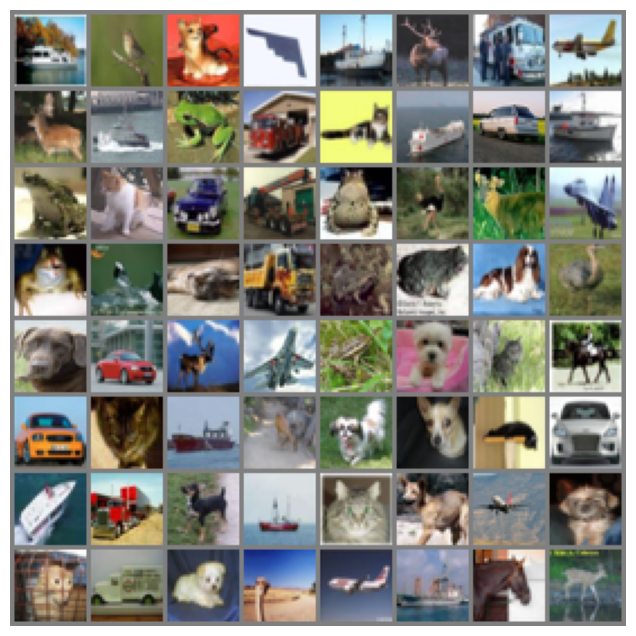

In [61]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [48]:

# Define hyperparameters for the convolutional layers
num_filters1 = 16
num_filters2 = 32


filter_size = 3
padding = 1  # To preserve spatial dimensions
stride_conv = 1  # Stride for convolutional layers
stride_pool = 2  # Stride for max-pooling layers
pool_kernel_size = 2  # Kernel size for max-pooling

channels = 3  # RGB images
height = 32
width = 32
num_classes = 10

# Function to calculate output dimensions after Conv or Pool layers
def calculate_output_size(input_size, kernel_size, padding, stride):
    return (input_size - kernel_size + 2 * padding) // stride + 1

# Calculate output dimensions after each Conv + Pool layer
# After Conv Layer 1
output_height1 = calculate_output_size(height, filter_size, padding, stride_conv)
output_width1 = calculate_output_size(width, filter_size, padding, stride_conv)

# After MaxPool Layer 1
output_height1_pool = output_height1 // stride_pool
output_width1_pool = output_width1 // stride_pool

# After Conv Layer 2
output_height2 = calculate_output_size(output_height1_pool, filter_size, padding, stride_conv)
output_width2 = calculate_output_size(output_width1_pool, filter_size, padding, stride_conv)

# After MaxPool Layer 2
output_height2_pool = output_height2 // stride_pool
output_width2_pool = output_width2 // stride_pool


# Update n_features based on the final output dimensions
n_features = num_filters2 * output_height2_pool * output_width2_pool

print(f"Final feature map size: {num_filters2} channels, {output_height2_pool}x{output_width2_pool}")
print(f"n_features: {n_features}")

class PrintSize(nn.Module):
    """Utility module to print the current shape of a Tensor in Sequential, only on the first forward pass."""
    def __init__(self):
        super(PrintSize, self).__init__()
        self.first = True
        
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        activation_fn = nn.ReLU
        dropout_rate = 0.7  # Dropout sandsynlighed
        
        self.net = nn.Sequential(
            PrintSize(),
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1),  # Conv Layer 1
            #nn.BatchNorm2d(16),
            activation_fn(),
            #nn.Dropout(dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2),
            PrintSize(),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),  # Conv Layer 2
            nn.BatchNorm2d(32),
            activation_fn(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2),
            PrintSize(),
            
            nn.Flatten(),  # Converts (batch_size, channels, height, width) to (batch_size, channels * height * width)
            nn.Linear(n_features, 128),
            activation_fn(),
            nn.Linear(128, 128),
            activation_fn(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Your code here!
        return self.net(x)


model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

Final feature map size: 32 channels, 8x8
n_features: 2048
Model(
  (net): Sequential(
    (0): PrintSize()
    (1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): PrintSize()
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.7, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): PrintSize()
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=2048, out_features=128, bias=True)
    (13): ReLU()
    (14): Linear(in_features=128, out_features=128, bias=True)
    (15): ReLU()
    (16): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [49]:
loss_fn = nn.CrossEntropyLoss()  # Your code here!
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Your code here!


## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [21]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Size: torch.Size([2, 3, 32, 32])
Size: torch.Size([2, 16, 16, 16])
Size: torch.Size([2, 32, 8, 8])
Output shape: torch.Size([2, 10])
Output logits:
[[-0.5138861   0.25818968  0.04450452 -0.15624423  0.14991114  0.21374711
  -0.18276072  0.19009106 -0.19833592  0.16804533]
 [-0.42568833 -0.21581668  0.27902788 -0.03112684  0.07581128  0.2692064
   0.3864607   0.19733445 -0.03969733  0.12889427]]
Output probabilities:
[[0.05842004 0.12643582 0.1021099  0.08353794 0.11346067 0.12093972
  0.08135192 0.11811233 0.08009466 0.11553696]
 [0.05979143 0.07375392 0.12097436 0.08871455 0.09872736 0.11979203
  0.1346948  0.11148446 0.08795748 0.10410969]]


In [50]:
batch_size = 64
num_epochs = 10
validation_every_steps = 500



step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()

        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Size: torch.Size([64, 3, 32, 32])
Size: torch.Size([64, 16, 16, 16])
Size: torch.Size([64, 32, 8, 8])
Step 500     training accuracy: 0.46546875
             test accuracy: 0.5355
Step 1000    training accuracy: 0.5877293577981652
             test accuracy: 0.6037
Step 1500    training accuracy: 0.6139375
             test accuracy: 0.6289
Step 2000    training accuracy: 0.654243119266055
             test accuracy: 0.6595
Step 2500    training accuracy: 0.6836444805194806
             test accuracy: 0.6676
Step 3000    training accuracy: 0.678
             test accuracy: 0.6767
Step 3500    training accuracy: 0.7008568548387096
             test accuracy: 0.6882
Step 4000    training accuracy: 0.7201388888888889
             test accuracy: 0.6789
Step 4500    training accuracy: 0.71259375
             test accuracy: 0.6948
Step 5000    training accuracy: 0.7231635551948052
             test accuracy: 0.6994
Step 5500    training accuracy: 0.7307692307692307
             test accuracy

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

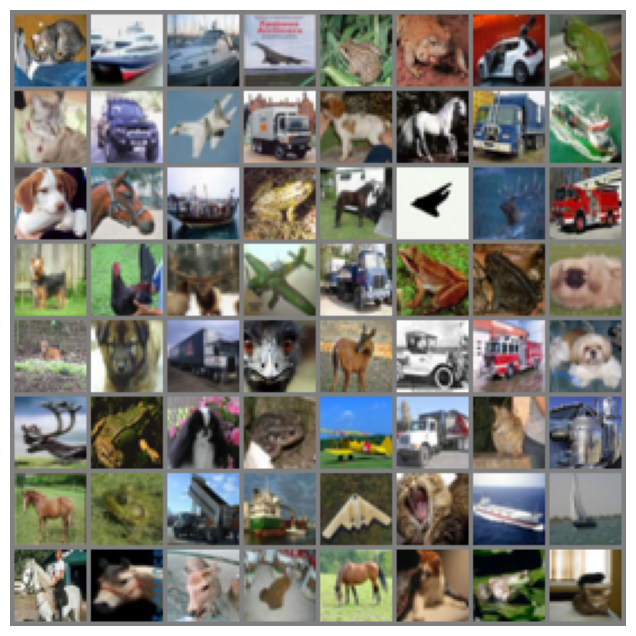

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane        ship     
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          frog     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse       airplane   
    ship          ship     
    frog          frog     
    horse         horse    
  airplane      airplane   
    deer        airplane   
    truck         truck    
     dog          deer     
    bird          deer     
    deer           cat     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog          deer     
    deer          bird     
     dog           c

In [51]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [52]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [53]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.721


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


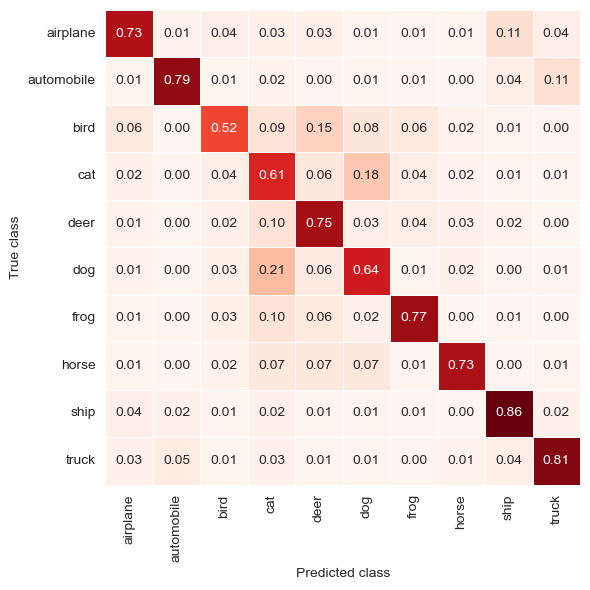

In [54]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

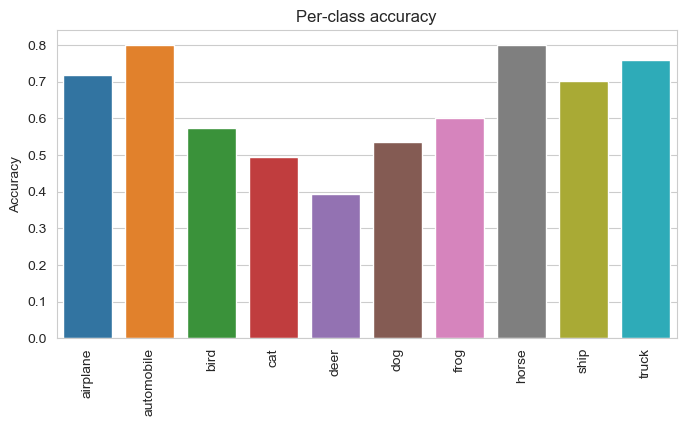

In [27]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?



3. Write down key lessons/insights you got during this exercise.

**Answer:**

# **Question 1 and 2:**

## Model Experimentation with CNN and MNIST

I started by doing the exercise: **"Introduction to CNN"** with the MNIST dataset. Here, I tested different variations of layers, batch size placement, dropout percentages, learning rates, etc. What worked best was the 2 and 4 layer convolutions. Among other things, I found that dropout worked best after the 3rd and 4th layers.

Even though they are two different datasets with different channels, the knowledge from MNIST was my best guide.

### Initial Model with 2 Convolution Layers

I started by running the model with two convolution layers, which had given the best results from MNIST.

After running the model with too few epochs, I removed dropout and batch normalization after the 1st convolutional layer and increased the epochs to 10, which led to the results you can see above. Perhaps the epochs could be increased to 15 to see what would happen.

### Model with 4 Convolution Layers

I then tried building the model with 4 convolution layers. This made the test accuracy worse than with only 2 convolution layers. So, I removed and added batch normalization and changed their positions relative to the convolution layers. The same was done with max pooling and dropout.

This resulted in an improvement in test accuracy compared to the model with 2 convolution layers.

**Test Accuracy Results:**
- **2 Convolution Layers** had an average test accuracy of: **72%** (The results can be seen above)
- **4 Convolution Layers** had an average test accuracy of: **81%** (You can scroll down to see the results)

What surprised me the most was that the placement of dropout worked best in the classification part of the model. I had expected that dropout would work best after the convolutional layers.


# **Question 3:**

## **Key Lessons/Insights** 
- Was that the model with 4 convolution layers performed better than the model with 2 convolution layers. 
- The placement of dropout worked best in the classification part of the model. I had expected that dropout would work best after the convolutional layers.
- **The WAITING TIME** for the model to train was longer than expected. I had expected the model to train faster than it did.
- I learned that the model can be improved by experimenting with the placement of layers, dropout, batch normalization, and learning rates.
- The model can be improved by increasing the number of epochs. 




# Assignment 4:

## Model (2Conv-layers)  (Se results above))
### *70%- 71% Test-accuracy*



In [65]:

# Define hyperparameters for the convolutional layers
num_filters1 = 16
num_filters2 = 32


filter_size = 3
padding = 1  # To preserve spatial dimensions
stride_conv = 1  # Stride for convolutional layers
stride_pool = 2  # Stride for max-pooling layers
pool_kernel_size = 2  # Kernel size for max-pooling

channels = 3  # RGB images
height = 32
width = 32
num_classes = 10

# Function to calculate output dimensions after Conv or Pool layers
def calculate_output_size(input_size, kernel_size, padding, stride):
    return (input_size - kernel_size + 2 * padding) // stride + 1

# Calculate output dimensions after each Conv + Pool layer
# After Conv Layer 1
output_height1 = calculate_output_size(height, filter_size, padding, stride_conv)
output_width1 = calculate_output_size(width, filter_size, padding, stride_conv)

# After MaxPool Layer 1
output_height1_pool = output_height1 // stride_pool
output_width1_pool = output_width1 // stride_pool

# After Conv Layer 2
output_height2 = calculate_output_size(output_height1_pool, filter_size, padding, stride_conv)
output_width2 = calculate_output_size(output_width1_pool, filter_size, padding, stride_conv)

# After MaxPool Layer 2
output_height2_pool = output_height2 // stride_pool
output_width2_pool = output_width2 // stride_pool


# Update n_features based on the final output dimensions
n_features = num_filters2 * output_height2_pool * output_width2_pool

print(f"Final feature map size: {num_filters2} channels, {output_height2_pool}x{output_width2_pool}")
print(f"n_features: {n_features}")

class PrintSize(nn.Module):
    """Utility module to print the current shape of a Tensor in Sequential, only on the first forward pass."""
    def __init__(self):
        super(PrintSize, self).__init__()
        self.first = True
        
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        activation_fn = nn.ReLU
        dropout_rate = 0.7  # Dropout sandsynlighed
        
        self.net = nn.Sequential(
            PrintSize(),
            nn.Conv2d(in_channels=3, out_channels=num_filters1, kernel_size=3, padding=1, stride=1),  # Conv Layer 1
            #nn.BatchNorm2d(16),
            activation_fn(),
            #nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            PrintSize(),
            
            nn.Conv2d(in_channels=num_filters1, out_channels=num_filters2, kernel_size=3, padding=1, stride=1),  # Conv Layer 2
           # nn.BatchNorm2d(32),
            activation_fn(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2),
            PrintSize(),
            
            nn.Flatten(),  # Converts (batch_size, channels, height, width) to (batch_size, channels * height * width)
            nn.Linear(n_features, 128),
            activation_fn(),
            nn.Linear(128, 128),
            activation_fn(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Your code here!
        return self.net(x)


model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()  # Your code here!
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Your code here!


Final feature map size: 32 channels, 8x8
n_features: 2048
Model(
  (net): Sequential(
    (0): PrintSize()
    (1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): PrintSize()
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Dropout(p=0.7, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): PrintSize()
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=2048, out_features=128, bias=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=128, bias=True)
    (14): ReLU()
    (15): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Model (4Conv-layers)  (Se results below))
### *78%- 80% test-accuracy*


In [65]:

class Model(nn.Module):

    
    def __init__(self, num_classes=10):
        super(Model, self).__init__()
        activation_fn = nn.ReLU
        dropout_rate = 0.5  
        
        self.features = nn.Sequential(
            # Conv Layer 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            activation_fn(),
           # nn.Dropout(dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            activation_fn(),
           # nn.Dropout(dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer 4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            activation_fn(),
           # nn.Dropout(dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Efter fire MaxPool lag på 32x32 billeder, bliver dimensionerne 2x2
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 2 * 2, 512),
            activation_fn(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            activation_fn(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()  # Your code here!
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Your code here!

Model(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

# Train the network

In [66]:
batch_size = 64
num_epochs = 20   
validation_every_steps = 500



step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()

        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.4243125
             test accuracy: 0.5274
Step 1000    training accuracy: 0.6047878440366973
             test accuracy: 0.5788
Step 1500    training accuracy: 0.64084375
             test accuracy: 0.691
Step 2000    training accuracy: 0.6952408256880734
             test accuracy: 0.6963
Step 2500    training accuracy: 0.7426948051948052
             test accuracy: 0.7318
Step 3000    training accuracy: 0.74371875
             test accuracy: 0.7424
Step 3500    training accuracy: 0.7757056451612904
             test accuracy: 0.7498
Step 4000    training accuracy: 0.8098958333333334
             test accuracy: 0.7753
Step 4500    training accuracy: 0.810625
             test accuracy: 0.7813
Step 5000    training accuracy: 0.832132711038961
             test accuracy: 0.7807
Step 5500    training accuracy: 0.8617788461538461
             test accuracy: 0.7871
Step 6000    training accuracy: 0.85434375
             test accuracy: 0.791
Step 6500    t

# Testing network

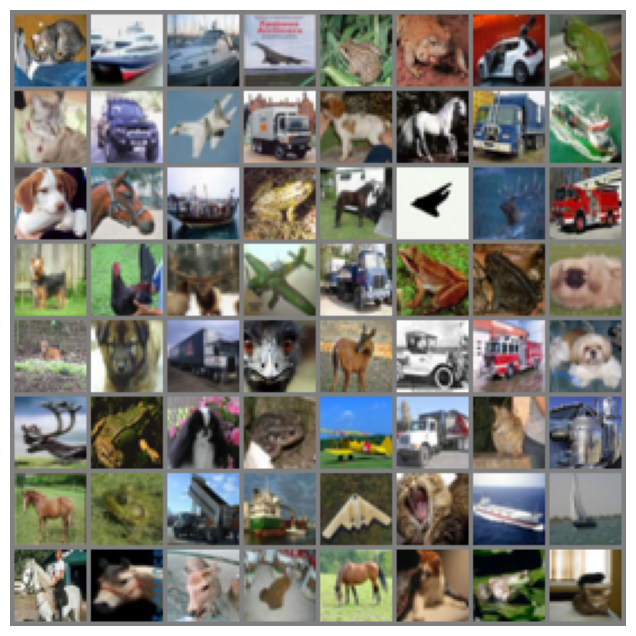

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane      airplane   
    frog          deer     
    frog          frog     
 automobile    automobile  
    frog          deer     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse         horse    
  airplane      airplane   
    deer          deer     
    truck         truck    
     dog          deer     
    bird           cat     
    deer          horse    
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          frog     
     dog           d

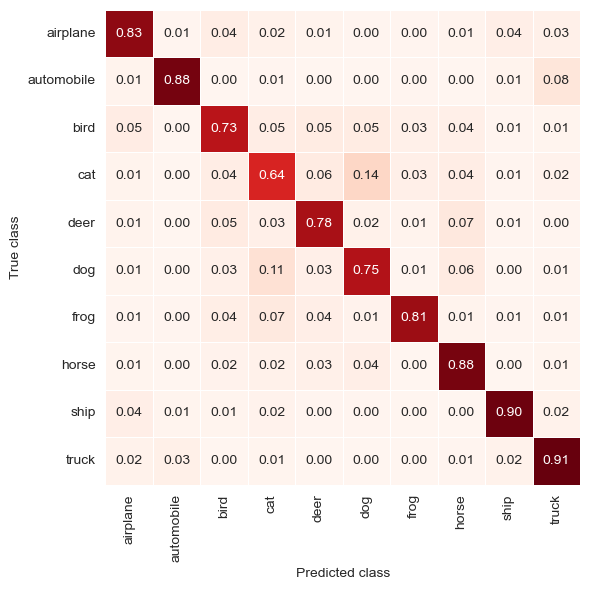

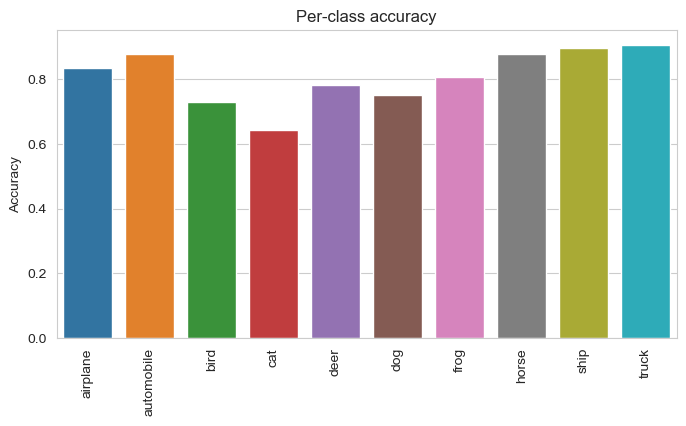

In [67]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()
print(f"Test accuracy: {test_accuracy:.3f}")

def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [14]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: []


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**





Can you tell, what is substituting into what more clearly:


The sigmoid function is defined as:

$$
\sigma(z) = \frac{1}{1 + \exp(-z)}
$$

Its derivative is given by:

$$
\sigma'(z) = \sigma(z) \cdot (1 - \sigma(z)) \tag{1}
$$

---

The derivative can also be expressed as:

$$
\sigma'(z) = \frac{\exp(-z)}{(1 + \exp(-z))^2} \tag{2}
$$

We will show that both expressions are equivalent.

First, we rewrite the right-hand side of equation (2):

$$
\frac{1}{1 + \exp(-z)} \cdot \left(1 - \frac{1}{1 + \exp(-z)}\right) \tag{3}
$$

We begin by calculating the expression inside the parentheses:

$$
1 - \frac{1}{1 + \exp(-z)} \tag{4}
$$

To simplify, rewrite 1 as:

$$
1 = \frac{1 + \exp(-z)}{1 + \exp(-z)} \tag{5}
$$

Subtracting the fractions:

$$
\frac{1 + \exp(-z)}{1 + \exp(-z)} - \frac{1}{1 + \exp(-z)} = \frac{\exp(-z)}{1 + \exp(-z)} \tag{6}
$$

Substituting back into equation (3):

$$
\frac{1}{1 + \exp(-z)} \cdot \frac{\exp(-z)}{1 + \exp(-z)} = \frac{\exp(-z)}{(1 + \exp(-z))^2} \tag{7}
$$

Thus, we've shown that:

$$
\sigma'(z) = \sigma(z) \cdot (1 - \sigma(z))
$$

